# Binary spine segmentation

> TODOs: upload models to hugginface

In [ ]:
from fastMONAI.vision_all import *
from sklearn.model_selection import train_test_split

In [ ]:
torch.cuda.set_device(0)

### Download external data

We use the MONAI function `DecathlonDataset` to download the data and generate items for training. 

In [ ]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'..'/'data'/'spine_data'/'processed' 

In [ ]:
fold = 3
df = pd.read_csv(DATA_DIR/'processed_csv'/'magnhild_data.csv')
df.loc[df.fold == fold, 'is_val'] = True 

### Look at training data

In [ ]:
med_dataset = MedDataset(img_list=df.t2_img_path.tolist(), reorder=True, max_workers=12)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([4.4, 0.7813, 0.7812], True)

In [ ]:
resample=[4.4, 0.78, 0.78]

In [ ]:
bs=4

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[17.0, 385.0, 385.0]

In [ ]:
size = [16,400,400]

In [ ]:
# refactorize
class BinaryConverter(DisplayedTransform):
    '''Convert BraTS masks.'''

    order=1

    def encodes(self, o:(MedImage)): return o

    def encodes(self, o:(MedMask)):
        o = torch.where(o>0, 1., 0)
        return MedMask.create(o)

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size), 
             RandomGamma(log_gamma=(-0.2,0.2), p=0.5), RandomAffine(scales=(0.9, 1.1), degrees=5, p=0.5), 
             RandomElasticDeformation(num_control_points=5, max_displacement=5.5, p=0.5), BinaryConverter()]

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=None,#ColSplitter('is_val'), # By passing valid_pct=0.1, we tell it to get a random 10% of the training set for validation.
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(12, 3)

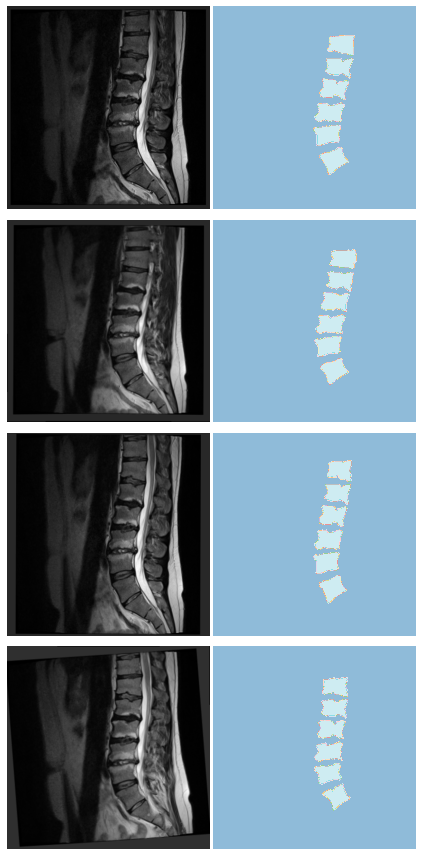

In [ ]:
dls.show_batch(unique=True, anatomical_plane=0) 

### Create and train a 3D model

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net. 
In the following line, we import an enhanced version of 3D UNet from MONAI. In addition, we import the Dice coefficient (Dice) loss, a commonly used loss function in medical image segmentation tasks: 
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

In [ ]:
from monai.networks.nets import UNet
from monai.losses import TverskyLoss, FocalLoss

TODO: refactorize

In [ ]:
from torch.nn.modules.loss import _Loss

class TverskyFocalLoss(_Loss):
    """
    Compute both Dice loss and Focal Loss, and return the weighted sum of these two losses.
    The details of Dice loss is shown in ``monai.losses.DiceLoss``.
    The details of Focal Loss is shown in ``monai.losses.FocalLoss``.
    """

    def __init__(
        self,
        include_background: bool = True,
        to_onehot_y: bool = False,
        sigmoid: bool = False,
        softmax: bool = False,
        other_act: Optional[Callable] = None,
        squared_pred: bool = False,
        jaccard: bool = False,
        reduction: str = "mean",
        smooth_nr: float = 1e-5,
        smooth_dr: float = 1e-5,
        batch: bool = False,
        gamma: float = 2.0,
        focal_weight: Optional[Union[Sequence[float], float, int, torch.Tensor]] = None,
        lambda_dice: float = 1.0,
        lambda_focal: float = 1.0,
    ) -> None:
        """
        """
        super().__init__()
        self.tversky = TverskyLoss(to_onehot_y=to_onehot_y, include_background=include_background, sigmoid=sigmoid, softmax=softmax, alpha=0.7, beta=0.3)
        self.focal = FocalLoss(to_onehot_y=to_onehot_y, include_background=include_background, gamma=gamma, weight=focal_weight, reduction=reduction)
       #if lambda_dice < 0.0:
         #   raise ValueError("lambda_dice should be no less than 0.0.")
        #if lambda_focal < 0.0:
          #  raise ValueError("lambda_focal should be no less than 0.0.")
        self.lambda_dice = lambda_dice
        self.lambda_focal = lambda_focal
        self.to_onehot_y = to_onehot_y
        self.include_background = include_background

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD]. The input should be the original logits
                due to the restriction of ``monai.losses.FocalLoss``.
            target: the shape should be BNH[WD] or B1H[WD].
        Raises:
            ValueError: When number of dimensions for input and target are different.
            ValueError: When number of channels for target is neither 1 nor the same as input.
        """
        if len(input.shape) != len(target.shape):
            raise ValueError("the number of dimensions for input and target should be the same.")

        n_pred_ch = input.shape[1]


        tversky_loss = self.tversky(input, target)
        focal_loss = self.focal(input, target)
        total_loss: torch.Tensor = self.lambda_dice * tversky_loss + self.lambda_focal * focal_loss
        return total_loss


In [ ]:
loss_func = CustomLoss(loss_func=TverskyFocalLoss(to_onehot_y=True, include_background=True, sigmoid=True))
model = UNet(spatial_dims=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2)
model = model.model
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=[multi_dice_score])

SuggestedLRs(valley=0.001737800776027143)

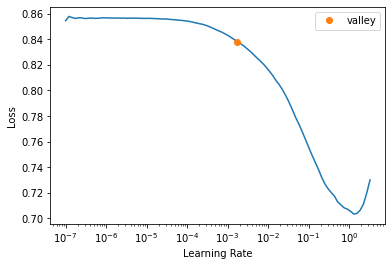

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_flat_cos(20 ,lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.831339,0.827995,0.068211,00:07
1,0.826379,0.803024,0.073456,00:06
2,0.808984,0.748459,0.060932,00:06
3,0.788949,0.735407,0.079995,00:07
4,0.774229,0.700708,0.089895,00:07
5,0.758337,0.696548,0.089500,00:07
6,0.745894,0.665654,0.099223,00:08
7,0.732043,0.663549,0.100180,00:07
8,0.720822,0.633775,0.107396,00:07
9,0.708379,0.633550,0.107506,00:07


In [ ]:
learn.show_results(anatomical_plane=0)